In [5]:
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import shap
import matplotlib.pylab as pl

# print the JS visualization code to the notebook
shap.initjs()

In [6]:
def load_and_prepare_data(file_name):
    """Load data from a CSV file and prepare it for modeling."""
    data = pd.read_csv(file_name)
    data.drop(columns=['text', 'cluster', 'named_entities'], inplace=True)  # Drop non-numeric or unnecessary columns
    X = data.drop(columns=['performance'])
    y = data['performance']
    return X, y

def train_and_evaluate(X, y):
    """Train the model and evaluate it on the test set, and calculate feature importances."""
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    feature_importances = model.feature_importances_
    return accuracy, report, feature_importances, model

def summarize_results(i, accuracy, report):
    """Summarize results for output, capturing metrics for both class 0 and class 1."""
    # Extract metrics for each class from the classification report
    class_0_metrics = report.get('0', {})
    class_1_metrics = report.get('1', {})

    return {
        'cluster': i,
        'overall_accuracy': accuracy,  # Overall accuracy is included once
        'precision_0': class_0_metrics.get('precision', 0),
        'recall_0': class_0_metrics.get('recall', 0),
        'f1-score_0': class_0_metrics.get('f1-score', 0),
        'support_0': class_0_metrics.get('support', 0),
        'precision_1': class_1_metrics.get('precision', 0),
        'recall_1': class_1_metrics.get('recall', 0),
        'f1-score_1': class_1_metrics.get('f1-score', 0),
        'support_1': class_1_metrics.get('support', 0)
    }

def collect_feature_importances(X_columns, feature_importances, cluster_id):
    """Collect feature importances into a single row for each cluster."""
    # Create a dictionary initializing with the cluster id
    feature_importance_dict = {'cluster': cluster_id}
    # Update the dictionary with feature importances
    feature_importance_dict.update({
        f'{feature}': importance for feature, importance in zip(X_columns, feature_importances)
    })
    return feature_importance_dict

In [7]:
summary_results = []
all_feature_importances = []
for i in range(1):  # Loop from 0_data.csv to 19_data.csv
    file_name = f'clusters csv\\{i}_data.csv'
    X, y = load_and_prepare_data(file_name)
    accuracy, report, feature_importances, model = train_and_evaluate(X, y)
    result = summarize_results(i, accuracy, report)
    summary_results.append(result)
    # Collect feature importances into a single dictionary for each cluster
    feature_importance_dict = collect_feature_importances(X.columns, feature_importances, i)
    all_feature_importances.append(feature_importance_dict)

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    shap.force_plot(explainer.expected_value, shap_values[0, :], X.columns)

In [8]:
file_name = f'clusters csv\\{i}_data.csv'
X, y = load_and_prepare_data(file_name)
accuracy, report, feature_importances, model = train_and_evaluate(X, y)
result = summarize_results(i, accuracy, report)
summary_results.append(result)
# Collect feature importances into a single dictionary for each cluster
feature_importance_dict = collect_feature_importances(X.columns, feature_importances, i)
all_feature_importances.append(feature_importance_dict)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value, shap_values[0, :], X.columns)

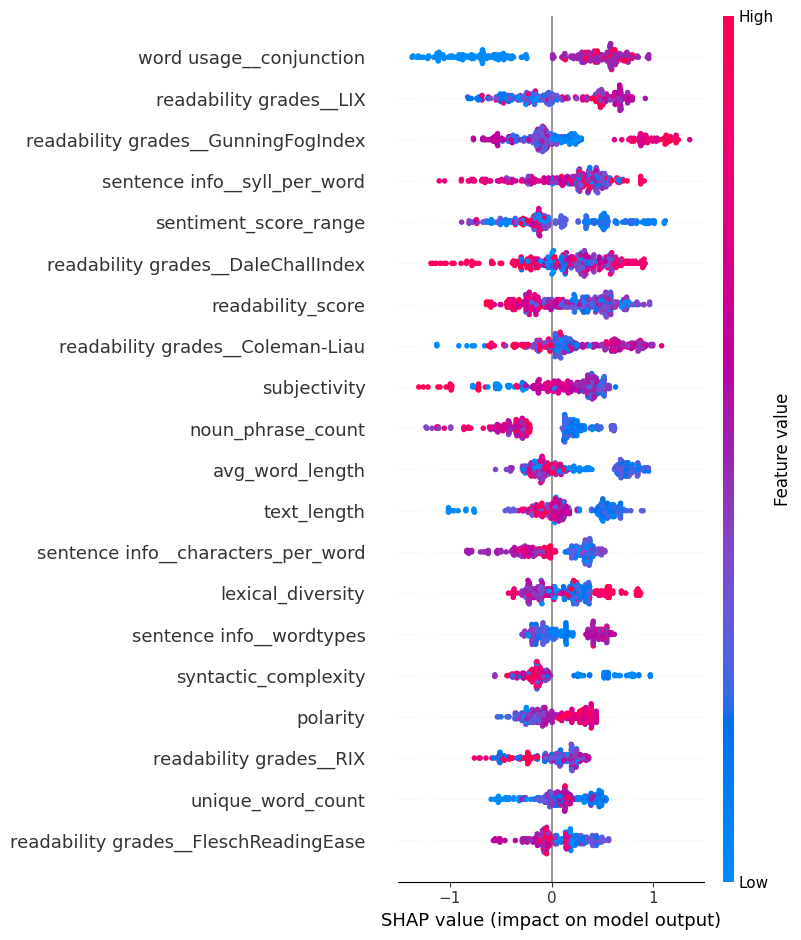

In [9]:
shap.summary_plot(shap_values, X)

In [12]:
import imblearn
import collections
import numpy
counter = collections.Counter(y)
for label, _ in counter.items():
    row_ix = where(y == label)[0]
    pl.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pl.legend()
pl.show()

Counter({1: 265, 0: 42})